In [1]:
import numpy as np
import shtns
import matplotlib.pyplot as plt
 
class Spharmt(object):
    """
    wrapper class for commonly used spectral transform operations in
    atmospheric models.  Provides an interface to shtns compatible
    with pyspharm (pyspharm.googlecode.com).
    """
    def __init__(self, nlons, nlats, ntrunc, rsphere, gridtype="gaussian"):
        """initialize
        nlons:  number of longitudes
        nlats:  number of latitudes"""
        self._shtns = shtns.sht(ntrunc, ntrunc, 1,
                                shtns.sht_orthonormal+shtns.SHT_NO_CS_PHASE)
 
        if gridtype == "gaussian":
            # self._shtns.set_grid(nlats, nlons,
            #         shtns.sht_gauss_fly | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_quick_init | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
        elif gridtype == "regular":
            self._shtns.set_grid(nlats, nlons,
                    shtns.sht_reg_dct | shtns.SHT_PHI_CONTIGUOUS, 1.e-10)
 
        self.lats = np.arcsin(self._shtns.cos_theta)
        self.lons = (2.*np.pi/nlons)*np.arange(nlons)
        self.nlons = nlons
        self.nlats = nlats
        self.ntrunc = ntrunc
        self.nlm = self._shtns.nlm
        self.degree = self._shtns.l
        self.lap = -self.degree*(self.degree+1.0).astype(complex)
        self.invlap = np.zeros(self.lap.shape, self.lap.dtype)
        self.invlap[1:] = 1./self.lap[1:]
        self.rsphere = rsphere
        self.lap = self.lap/rsphere**2
        self.invlap = self.invlap*rsphere**2
 
    def grdtospec(self, data):
        """compute spectral coefficients from gridded data"""
        return self._shtns.analys(data)
 
    def spectogrd(self, dataspec):
        """compute gridded data from spectral coefficients"""
        return self._shtns.synth(dataspec)
 
    def getuv(self, vrtspec, divspec):
        """compute wind vector from spectral coeffs of vorticity and divergence"""
        return self._shtns.synth((self.invlap/self.rsphere)*vrtspec, (self.invlap/self.rsphere)*divspec)
 
    def getvrtdivspec(self, u, v):
        """compute spectral coeffs of vorticity and divergence from wind vector"""
        vrtspec, divspec = self._shtns.analys(u, v)
        return self.lap*self.rsphere*vrtspec, self.lap*rsphere*divspec
 
    def getgrad(self, divspec):
        """compute gradient vector from spectral coeffs"""
        vrtspec = np.zeros(divspec.shape, dtype=complex)
        u, v = self._shtns.synth(vrtspec, divspec)
        return u/rsphere, v/rsphere

In [2]:
# grid, time step info
nlons = 512                 # number of longitudes
ntrunc = int(nlons/3)       # spectral truncation (for alias-free computations)
nlats = int(nlons/2)        # for gaussian grid.
dt = 150                    # time step in seconds
itmax = 6*int(86400/dt)     # integration length in days

# parameters for test
rsphere = 6.37122e6         # earth radius
omega = 7.292e-5            # rotation rate
grav = 9.80616              # gravity
hbar = 10.e3                # resting depth
umax = 80.                  # jet speed
phi0 = np.pi/7.
phi1 = 0.5*np.pi - phi0
phi2 = 0.25*np.pi
en = np.exp(-4.0/(phi1-phi0)**2)
alpha = 1./3.
beta = 1./15.
hamp = 120.                 # amplitude of height perturbation to zonal jet
efold = 3.*3600.            # efolding timescale at ntrunc for hyperdiffusion
ndiss = 8                   # order for hyperdiffusion

# setup up spherical harmonic instance, set lats/lons of grid
x = Spharmt(nlons, nlats, ntrunc, rsphere, gridtype="gaussian")
lons, lats = np.meshgrid(x.lons, x.lats)
f = 2.*omega*np.sin(lats)   # coriolis

In [3]:
ug = 10.0 + np.zeros((nlats, nlons), float)
vg = np.zeros((nlats, nlons), float)
uspec = x.grdtospec(ug)
vspec = x.grdtospec(vg)

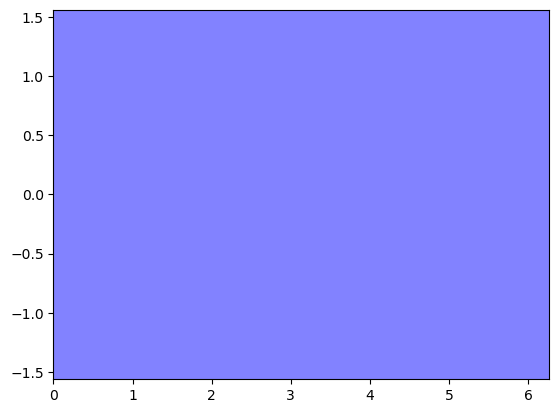

In [4]:
plt.contourf(lons, lats, ug, levels = 32, cmap = "bwr")

In [5]:
vrtg_tmp, divg_tmp = x.getvrtdivspec(ug, vg)
vrtg_tmp = x.spectogrd(vrtg_tmp)


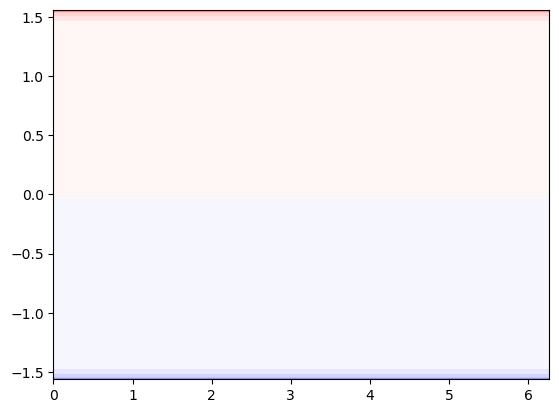

In [6]:
plt.contourf(lons, lats, vrtg_tmp, levels = 32, cmap = "bwr")

In [7]:
np.max(np.abs(vrtg_tmp))

0.00021863900129364593